# Example of analysis script to get upper limits using csdmatter app

The goal is to show you how to use the csdmatter app to compute exclusion limits to the annihilation cross-section using the PPPC4DMID tables.

We start by importing `gammalib` and `ctools`, alongside the csdmatter.

In [1]:
#   Default imports
import gammalib
import ctools
import cscripts

from ctaAnalysis.csdmatter import csdmatter

import os

We used the observation from the previous example notebook `dmsimulation.ipynb`. You can use your own observations too. As other `ctools` and `gammalib` apps, you can directly pass the observation container from other tools/apps. This is only valid for On observations, and not for On/Off observations generated with `csphagen` (still working to solve the issue)

In [2]:
#   Name of fits with events from a dm simulation
#   The fits I am using here is obtained from 
#   the example "Simulation of gamma-ray emission from a Toy Dark halo"
file = 'Haloobssim.fits'

## Input parameters

The following shows all the input parameters required to initialize the `csdmatter` class.

Due to numerical precision issues, `csdmatter` handles the creation of `GModelSpectralTable` models *in-fly*. The models are created for the channel indicated in the input parameters, and a new range of masses around the dark-matter mass tested. This is also to properly analysis `GCTAOnOff` observations (please check the notebooks for an example). You can still use `GModelSpectralTable` models created with `dmtable` class (including all the channels) to simulate observations.

In [3]:
#   csdmatter App input parameters
#   I know there are a lot of input parameters
#   And, at some point, some of the parameters can change, BTW
mmin          = 100.0         #   Minimum value of mass range to compute ULs (in GeV)
mmax          = 1.e+5         #   Maximum value of mass range to compute ULs (in GeV)
mnumpoints    = 10            #   Number of points to compute in the range [mmin,mmax]
process       = 'ANNA'        #   Process
channel       = 'b'           #   annihilation channel
ewcorrections = True          #   include EW corrections. I am using PPPC4DMID tables
logsigmav     = -25.443697    #   Log of sigmav (~3.6e-26)
logastfactor  = 18.7          #   Log of Jfactor
emin          = 30            #   Minimum energy to compute gamma-ray flux (in GeV)
emax          = 1.e+5         #   Maximum energy to compute gamma-ray flux (in GeV)
modtype       = 'PointSource' #   Model type
ra            = 80.6          #   in degrees
dec           = 23.5          #   in degrees
nthreads      = 4             #   Number of threads
caldb         = 'prod3b-v2'
irf           = 'North_z40_50h'
srcname       = 'ToyDarkHalo' #   name of the source

Finally, you can choose a name to save the results in a fits file. Also you can use the method `dmatter_fits()` to retrieve the fits container

In [4]:
#   Name of file to save results for every simulation
ofname = 'dmResultsExample{0}.fits'.format(srcname)

## Create an instance of csdmatter tool

Now, we can create an instance of `csdmatter` (`thistool`), and excute it.

In [5]:
#   Create instance of csdmatter app
thistool = csdmatter()

#   Passing input parameter to the app
thistool['inobs']         = file
thistool['srcname']       = srcname
thistool['mmin']          = mmin
thistool['mmax']          = mmax
thistool['mnumpoints']    = mnumpoints
thistool['process']       = process
thistool['channel']       = channel
thistool['ewcorrections'] = ewcorrections
thistool['logsigmav']     = logsigmav
thistool['logastfactor']  = logastfactor
thistool['emin']          = emin
thistool['emax']          = emax
thistool['modtype']       = modtype
thistool['ra']            = ra
thistool['dec']           = dec
thistool['caldb']         = caldb
thistool['irf']           = irf
thistool['nthreads']      = nthreads
thistool['outfile']       = ofname
thistool['clobber']       = True
thistool['eblmodel']      = 'dominguez'
thistool['redshift']      = 0.01
thistool['debug']         = True
thistool['chatter']       = 4
thistool.logFileOpen()

In [6]:
#   Then, execute the csdmatter tool
thistool.execute()

50it [00:45,  1.09it/s]
50it [00:48,  1.02it/s]
50it [00:49,  1.01it/s]
50it [00:48,  1.03it/s]
50it [00:58,  1.16s/it]
50it [00:55,  1.11s/it]
50it [00:53,  1.07s/it]
50it [00:50,  1.02s/it]
50it [00:52,  1.06s/it]
50it [00:37,  1.33it/s]


## Checking the results

After several minutes, we can take a look at the results by loading the fits file. First, we retrieve the names of the different columns within the results. Then, accessing the `Mass` and `ULCrossSection` columns, we can get a plot for this example. For some cases, I got `nan` values for the flux obtained with `ctulimit`, but not sure why. More testing on this. By now, remove `nan` values from list

In [7]:
#   Take a look to the results
fits  = gammalib.GFits(ofname)
table = fits.table(1)

#   Check the name of the different colums saved in the fits
for ncol in range(table.ncols()) :
    print(table[ncol].name())

MinEnergy
MaxEnergy
Mass
Flux
ErrFlux
E2Flux
E2ErrFlux
LogL
TS
UpperLimit
ScaleFactor
ULCrossSection
RefCrossSection


In [8]:
#   Get masses and values of the upperlimits
masses   = [row for row in table['Mass']]
sigmavul = [row for row in table['ULCrossSection']]
print('Mass (GeV)\tUL[sigmav](cm**3/s)\t')
for nrow in range(table.nrows()) :
    print('{:.2e}:\t\t{:.3e}'.format(table['Mass'][nrow], table['ULCrossSection'][nrow]))

Mass (GeV)	UL[sigmav](cm**3/s)	
1.00e+02:		1.218e-23
2.16e+02:		4.184e-24
4.65e+02:		3.424e-24
1.00e+03:		5.172e-24
2.16e+03:		8.308e-24
4.64e+03:		1.499e-23
1.00e+04:		3.283e-23
2.15e+04:		9.395e-23
4.64e+04:		3.476e-22
1.00e+05:		1.555e-21


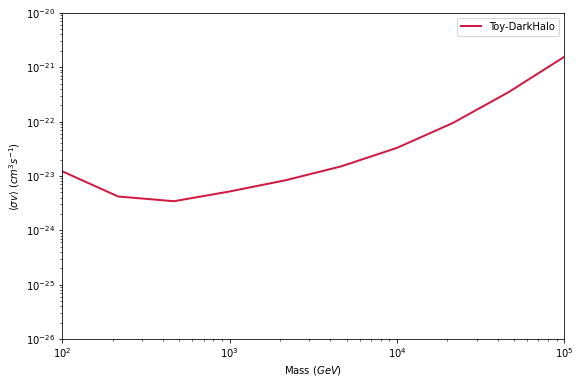

In [9]:
#   Plot the results
import matplotlib.pyplot as plt

#removing index 8 from masses and sigmavul
# del masses[8]
# del sigmavul[8]

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(masses, sigmavul, color=(0.82, 0.10, 0.26), lw=2, label='Toy-DarkHalo')

ax.set_xlim(1.e+2, 1.e+5)
ax.set_ylim(1.e-26, 1.e-20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mass $(GeV)$')
ax.set_ylabel('$\\langle\\sigma v\\rangle$ ($cm^{3} s^{-1}$)')

ax.legend(loc='best', prop={'size':10})

plt.show()

In [10]:
print('Mass (GeV)\tScale Factor\t')
for nrow in range(table.nrows()) :
    print('{:.2e}:\t\t{:.3e}'.format(table['Mass'][nrow], table['ScaleFactor'][nrow]))

Mass (GeV)	Scale Factor	
1.00e+02:		3.384e+02
2.16e+02:		1.162e+02
4.65e+02:		9.512e+01
1.00e+03:		1.437e+02
2.16e+03:		2.308e+02
4.64e+03:		4.165e+02
1.00e+04:		9.120e+02
2.15e+04:		2.610e+03
4.64e+04:		9.656e+03
1.00e+05:		4.319e+04


In [11]:
print('Mass (GeV)\tUpper Limit\t')
for nrow in range(table.nrows()) :
    print('{:.2e}:\t{:.3e}'.format(table['Mass'][nrow], table['UpperLimit'][nrow]))

Mass (GeV)	Upper Limit	
1.00e+02:	6.369e-11
2.16e+02:	1.436e-11
4.65e+02:	4.412e-12
1.00e+03:	1.932e-12
2.16e+03:	7.885e-13
4.64e+03:	3.449e-13
1.00e+04:	1.841e-13
2.15e+04:	1.315e-13
4.64e+04:	1.219e-13
1.00e+05:	1.344e-13


In [12]:
thistool.logFileClose()